In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sunpy
import sunpy.map
import cv2
import random
from tqdm.notebook import tqdm
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from astropy.time import Time
from scipy.io import readsav
from copy import deepcopy
from sun_blinker import ImageBlinker, SunBlinker

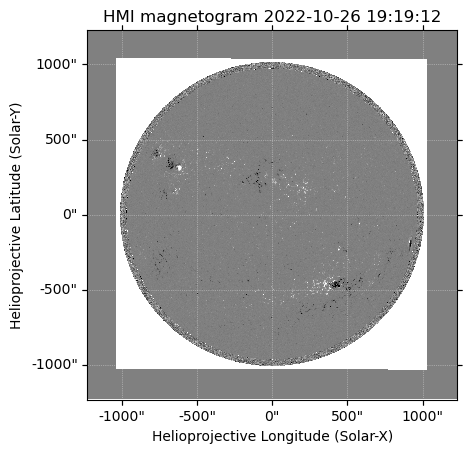

In [2]:
hmi_los_map = sunpy.map.Map("../../src/HMI/20221026/lvl15/hmi.M_45s.20221026_192015_TAI.2.magnetogram.fits")
hmi_los_map.plot_settings['norm'] = plt.Normalize(-500, 500)
hmi_los_map.plot()

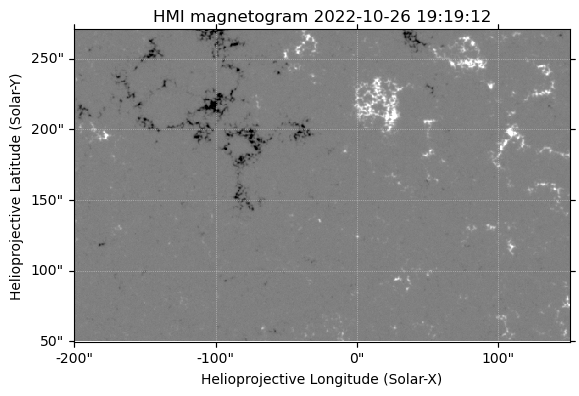

In [12]:
hmi_los_map_crop = hmi_los_map.submap(SkyCoord(-200*u.arcsec,50*u.arcsec,frame=hmi_los_map.coordinate_frame),
                                        top_right=SkyCoord(150*u.arcsec,270*u.arcsec,frame=hmi_los_map.coordinate_frame))
hmi_los_map_crop.plot()

In [13]:
with fits.open("../../src/SOTSP/20221026/lvl2/20221026_184140.fits") as hdul:
    sotsp_header = deepcopy(hdul[0].header)
    # for keys in hdul[1].header.keys():
    #     sotsp_header[keys] = hdul[1].header[keys]
    sotsp_header['CUNIT1'] = 'arcsec'
    sotsp_header['CUNIT2'] = 'arcsec'
    sotsp_header['CTYPE1'] = 'HPLN-TAN'
    sotsp_header['CTYPE2'] = 'HPLT-TAN'
    sotsp_header['CRVAL1'] = sotsp_header['XCEN']
    sotsp_header['CRVAL2'] = sotsp_header['YCEN']
    sotsp_header['CDELT1'] = 0.297 #from Fouhey et al. 2023
    sotsp_header['CDELT2'] = 0.320
    sotsp_header['NAXIS'] = 2
    # sotsp_header['RSUN_REF'] = sotsp_header['SOLAR_RA']
    # sotsp_header['DATE-OBS'] = sotsp_header['TSTART']
    # sotsp_header["DATE-END"] = sotsp_header['TEND']
    sotsp_header["DATE-AVG"] = (Time(sotsp_header["TSTART"]) + \
                                (Time(sotsp_header["TEND"]) - Time(sotsp_header["TSTART"]))/2).strftime("%Y-%m-%dT%H:%M:%S")
    
# with fits.open("../../src/SOTSP/20221024/lvl2/sotsp_l2_20221024_190447_3643101203_20221024_184138_magfield_index.fits") as hdul:
#     lsmal_header = deepcopy(hdul[0].header)
#     sotsp_header["PC1_1"] = lsmal_header["PC1_1"]
#     sotsp_header["PC1_2"] = lsmal_header["PC1_2"]
#     sotsp_header["PC2_1"] = lsmal_header["PC2_1"]
#     sotsp_header["PC2_2"] = lsmal_header["PC2_2"]

sotsp_corr_file = readsav("../../src/SOTSP/20221026/lvl2/sotsp_lvl2_missing_col_corrected.sav")
sotsp_btot = deepcopy(sotsp_corr_file['data_new'][0,:,:])
sotsp_binc = deepcopy(sotsp_corr_file['data_new'][1,:,:])
sotsp_btot[~np.isfinite(sotsp_btot)] = 0
sotsp_binc[~np.isfinite(sotsp_binc)] = 0


In [14]:
sotsp_corr_file['data_new'].shape

(38, 512, 1000)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


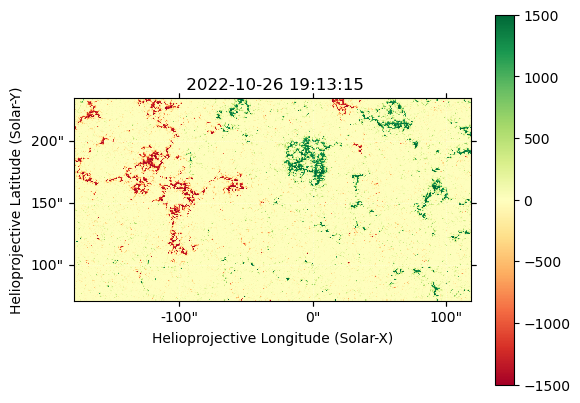

In [15]:
sotsp_btot_map = sunpy.map.Map(sotsp_btot*np.cos(np.deg2rad(sotsp_binc)),sotsp_header).rotate()
sotsp_btot_map.meta["rsun_ref"] = 696000000.
sotsp_btot_map.plot_settings['cmap'] = "RdYlGn"
sotsp_btot_map.plot_settings['norm'] = plt.Normalize(-1500, 1500)
sotsp_btot_map.plot()
plt.colorbar()

In [16]:
hmi_img = hmi_los_map_crop.data
hmi_img = cv2.resize(hmi_img, (hmi_img.shape[1]*2, hmi_img.shape[0]*2), interpolation=cv2.INTER_LINEAR)
hmi_img = cv2.normalize(hmi_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
sotsp_img = sotsp_btot_map.data
sotsp_img = cv2.normalize(sotsp_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

In [17]:
sift = cv2.SIFT_create()
kp_hmi, des_hmi = sift.detectAndCompute(hmi_img, None)
kp_sotsp, des_sotsp = sift.detectAndCompute(sotsp_img, None)

In [18]:
hmi_img_kp = cv2.drawKeypoints(hmi_img, kp_hmi, 0, (0, 0, 255), 
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
sotsp_img_kp = cv2.drawKeypoints(sotsp_img, kp_sotsp, 0, (0, 0, 255),
                                    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

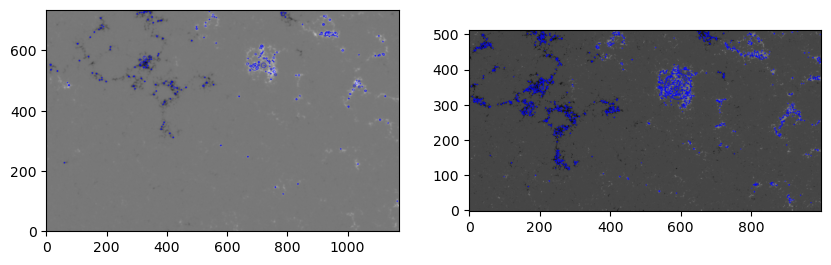

In [19]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(hmi_img_kp, origin="lower")
ax2.imshow(sotsp_img_kp, origin="lower")

In [28]:
def matcher(des1, des2,threshold=1):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 100)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < threshold*n.distance:
            good.append(m)

    return good

In [45]:
hmi_sot_good_matches = matcher(des_sotsp, des_hmi, 0.8)

In [46]:
def homography(kp1, kp2, matches):
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    # h,w = img1.shape
    # pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    # dst = cv2.perspectiveTransform(pts,M)
    # img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    return M, matchesMask

In [47]:
hmi_sot_matrix, hmi_sot_matchesmask = homography(kp_sotsp, kp_hmi, hmi_sot_good_matches)

In [48]:
match_draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = hmi_sot_matchesmask, # draw only inliers
                   flags = 2)
hmi_sot_matches_img = cv2.drawMatches(sotsp_img,kp_sotsp,hmi_img,kp_hmi,hmi_sot_good_matches,None,**match_draw_params)

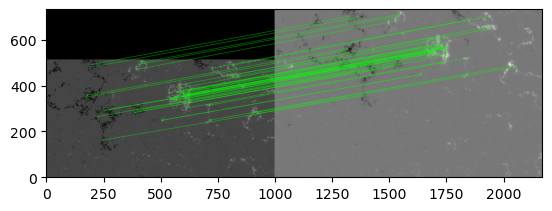

In [49]:
plt.imshow(hmi_sot_matches_img,origin="lower")

In [50]:
sotsp_img_warp = cv2.warpPerspective(sotsp_img,hmi_sot_matrix, dsize=(hmi_img.shape[1],hmi_img.shape[0]),
                                     borderMode=cv2.BORDER_CONSTANT, borderValue=np.nan)

In [51]:
ImageBlinker(sotsp_img_warp, hmi_img, fps=0.5)

In [52]:
hmi_los_map_crop_resize = hmi_los_map_crop.resample([hmi_los_map_crop.data.shape[1],hmi_los_map_crop.data.shape[0]]*u.pixel*2)

In [53]:
sotsp_br_img_warp = cv2.warpPerspective(sotsp_btot_map.data,hmi_sot_matrix, dsize=(hmi_img.shape[1],hmi_img.shape[0]),
                                        borderMode=cv2.BORDER_CONSTANT, borderValue=np.nan)
sotsp_br_warp_map = sunpy.map.Map(sotsp_br_img_warp, hmi_los_map_crop_resize.wcs)
sotsp_br_warp_map.meta["instrume"] = "SOT/SP"
sotsp_br_warp_map.meta["rsun_ref"] = 696000000.
sotsp_br_warp_map.meta["telescop"] = "HINODE"
sotsp_br_warp_map.meta["data_lev"] = 2
sotsp_br_warp_map.meta["comment"] = "SOT/SP Level 2 Br magnetogram warped to HMI LOS magnetogram using SIFT and RANSAC"
sotsp_br_warp_map = sunpy.map.Map(sotsp_br_warp_map.data, sotsp_br_warp_map.meta)

In [54]:
def crop_to_drop_boundary(map):
    data = map.data
    nan_mask = np.isnan(data)
    nan_mask_col = np.all(nan_mask, axis=0)
    nan_mask_row = np.all(nan_mask, axis=1)
    bottom_left = [nan_mask_col.argmin(), nan_mask_row.argmin()]*u.pix
    top_right = [nan_mask_col.size - nan_mask_col[::-1].argmin(), nan_mask_row.size - nan_mask_row[::-1].argmin()]*u.pix

    map_crop = map.submap(bottom_left, top_right=top_right)
    
    return map_crop

In [55]:
sotsp_br_warp_map = crop_to_drop_boundary(sotsp_br_warp_map)

In [56]:
sotsp_br_warp_map.save("../../src/coalign_map/20221026/sotsp_br_warp_to_hmi.fits", overwrite=True)

 [astropy.io.fits.verify]


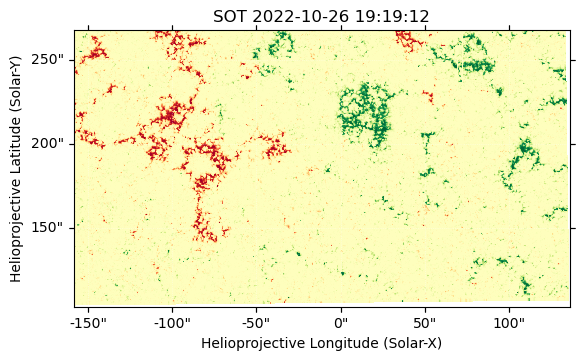

In [58]:
sotsp_br_warp_map.plot(cmap="RdYlGn",norm=plt.Normalize(-1500,1500))